# Training and Evaluating Models with the Data-Driven Library

This notebook provides an overview of the tools built in the DDM for extracting predictions from your trained DDM and for evauating the performance of the DDM.

---

We utilize `hydra` to save the configuration of our datasets and our models. The default configuration is in the `conf/config.yaml` directory:

```YAML
defaults:
  - data: house_energy.yaml
  - model: xgboost.yaml
  - simulator: house_energy_simulator.yaml
```

Note that the configuration file points to three additional configuration files for each component: the data, the model, and the simulator.

While the configuration file already has default values specified you can override any element of the configuration file using the `overrides` option. For example, we can override the data configuration to instead use the `yaml` file specified in `data/cartpole-100K-cts.csv.yaml` and the model configuration to use the `yaml` file specified in `model/SVR.yaml`.


In [1]:
cd ..

/home/alizaidi/bonsai/datadrivenmodel


In [2]:
from hydra.experimental import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from model_loader import available_models
import logging
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.logging import RichHandler
import copy
from assessment_metrics_loader import available_metrics

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler()]
)
logger = logging.getLogger("ddm_notebook")
logger.setLevel(logging.INFO)

In [3]:
GlobalHydra.instance().clear() 
initialize(config_path="../conf", job_name="model_train_validate")
# cfg = compose(config_name="config", overrides=["data=house_energy", "model=xgboost", "simulator=house_energy_simparam"])
cfg = compose(config_name="config", overrides=["data=cartpole_st1_at", "model=xgboost", "simulator=cartpole_simparam"])


/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/cartpole_st1_at.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/xgboost.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/anaconda/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive simulator/cartpole_simparam.yaml in file:///home/alizaidi/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning

## 1. Importing the Dataset

In [4]:
# Extract features from yaml file
from numpy import concatenate


input_cols = cfg['data']['inputs']
output_cols = cfg['data']['outputs']
augmented_cols = cfg['data']['augmented_cols']
dataset_path = cfg['data']['path']
iteration_order = cfg['data']['iteration_order']
episode_col = cfg['data']['episode_col']
iteration_col = cfg['data']['iteration_col']
# max_rows = cfg['data']['max_rows']
max_rows = 50_000
diff_state = cfg['data']['diff_state']
test_perc = cfg['data']['test_perc']
concatenated_steps = cfg["data"]["concatenated_steps"]
concatenated_zero_padding = cfg["data"]["concatenated_zero_padding"]

In [5]:
print("DATA STRUCTURE SELECTED:")
print(" - input_cols:", input_cols)
print(" - augmented_cols:", augmented_cols)
print(" - output_cols:", output_cols)

DATA STRUCTURE SELECTED:

- input_cols: state

- augmented_cols: ['config_length', 'config_masspole', 'action_command']

- output_cols: state

##  2. Model Definition

The `available_models` dictionary provides wrappers for the available models in this repository. We utilize `cfg["model"]` to load and build the model specified in the `model.yaml` file.

### Hyperparameters

Every model has its own hyperparameters, specified through the `cfg["model"]["build_params"]` dictionary, which can be modified directly in the dictionary below or through the `hydra` overrides.

In [6]:
cfg["model"]["build_params"]

{'model_type': 'xgboost', 'fit_separate': False, 'halt_model': False, 'n_estimators': 100, 'objective': 'reg:squarederror', 'learning_rate': 0.3, 'scale_data': True, 'max_depth': 6}

## 3. Train the Model

In [7]:
def train_models(config=cfg):

    logger.info(f'Model type: {available_models[config["model"]["name"]]}')
    Model = available_models[config["model"]["name"]]
    model = Model()
    logger.info(f"Building model with parameters: {config}")
    model.build_model(
        **config["model"]["build_params"]
    )
    logger.info(f"Loading data from {dataset_path}")
    global X_train, y_train, episode_ids_train, X_test, y_test
    X_train, y_train, X_test, y_test = model.load_csv(
        input_cols=input_cols,
        output_cols=output_cols,
        augm_cols=list(augmented_cols),
        dataset_path=dataset_path,
        iteration_order=iteration_order,
        episode_col=episode_col,
        iteration_col=iteration_col,
        max_rows=max_rows,
        diff_state=diff_state,
        test_perc=test_perc,
        concatenated_steps=concatenated_steps,
        concatenated_zero_padding=concatenated_zero_padding
    )
    
    logger.info(f"Fitting model...")
    model.fit(X_train, y_train)
    logger.info(f"Model trained!")
    y_pred = model.predict(X_test)
    r2_score = available_metrics["r2_score"]
    logger.info(f"R^2 score is {r2_score(y_test,y_pred)} for the test set.")

    return model

In [8]:
model = train_models(cfg)

[05:25:03] INFO     Model type: <class 'gboost_models.GBoostModel'>                ]8;id=589399;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=329719;file://<ipython-input-7-91aecc39f520>#3\3]8;;\

           INFO     Building model with parameters: {'data': {'path':              ]8;id=123744;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=462781;file://<ipython-input-7-91aecc39f520>#6\6]8;;\
                    'csv_data/cartpole_st1_at.csv', 'full_or_relative':                                            
                    'relative', 'inputs': 'state', 'outputs': 'state',                                             
                    'augmented_cols': ['config_length', 'config_masspole',                                         
                    'action_command'], 'iteration_order': -1, 'episode_col':                                       
                    'episode', 'iteration_col': 'iteration', 'max_rows': -1,                                       
                    'scale_data': True, 'diff_state': False, 'concatenated_steps':                                 
                    4, 'concatenated_zero_padding': True, 'test_perc': 0.25},                                      
                    'model': {'name': 'xgboost', 'build_params': {'model_type':                                    
                    'xgboost', 'fit_separate': False, 'halt_model': False,                                         
                    'n_estimators': 100, 'objective': 'reg:squarederror',                                          
                    'learning_rate': 0.3, 'scale_data': True, 'max_depth': 6},                                     
                    'saver': {'filename': 'models/xgboost_models/house_energy'},                                   
                    'sweep': {'run': False, 'split_strategy': 'timeseries',                                        
                    'search_algorithm': 'bayesian', 'num_trials': 15,                                              
                    'scoring_func': 'r2', 'early_stopping': False,                                                 
                    'results_csv_path': 'xgboost_gridsearch/search_results.csv',                                   
                    'params': {'estimator__max_depth': [1, 3, 5, 10],                                              
                    'estimator__gamma': [0, 0.5, 1, 5], 'estimator__subsample':                                    
                    [0.1, 0.5, 1], 'estimator__eta': [0.3, 0.1, 0.5]}}},                                           
                    'simulator': {'states': ['state_x_position',                                                   
                    'state_x_velocity', 'state_angle_position',                                                    
                    'state_angle_velocity'], 'actions': ['action_command'],                                        
                    'configs': ['config_length', 'config_masspole'],                                               
                    'episode_inits': None, 'initial_states': {'state_x_position':                                  
                    0, 'state_x_velocity': 0, 'state_angle_position': 0,                                           
                    'state_angle_velocity': 0}, 'signal_builder': None, 'policy':                                  
                    'bonsai', 'logging': 'enable', 'workspace_setup': True}}                                       

           INFO     Loading data from csv_data/cartpole_st1_at.csv                ]8;id=375020;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=370303;file://<ipython-input-7-91aecc39f520>#10\10]8;;\

           INFO     Using ['state_x_position', 'state_x_velocity', 'state_angle_position',         ]8;id=617947;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=658451;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#320\320]8;;\
                    'state_angle_velocity', 'config_length', 'config_masspole', 'action_command']                  
                    as the features for modeling DDM                                                               

           INFO     Using ['state_x_position', 'state_x_velocity', 'state_angle_position',         ]8;id=525821;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=612054;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#331\331]8;;\
                    'state_angle_velocity'] as the labels for modeling DDM                                         

           INFO     Iteration order set to -1 so using inputs from previous -1 row                  ]8;id=119816;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=166971;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#86\86]8;;\

           INFO     Feature columns are: ['prev_state_x_position', 'prev_state_x_velocity',        ]8;id=41563;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=75569;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#127\127]8;;\
                    'prev_state_angle_position', 'prev_state_angle_velocity', 'config_length',                     
                    'config_masspole', 'action_command']                                                           

           INFO     Label columns are: ['state_x_position', 'state_x_velocity',                    ]8;id=556031;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=449197;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#128\128]8;;\
                    'state_angle_position', 'state_angle_velocity']                                                

           INFO     Trimmed DataFrame across episodes. found (1000) episodes.                      ]8;id=321862;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=514274;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#412\412]8;;\

           INFO     Using previous 4 lags for all features as inputs and using padding: True       ]8;id=939348;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=342168;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#367\367]8;;\

[05:25:04] INFO     Features after incorporating lagged features: ['prev_state_x_position_1',      ]8;id=358835;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=389800;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#809\809]8;;\
                    'prev_state_x_velocity_1', 'prev_state_angle_position_1',                                      
                    'prev_state_angle_velocity_1', 'config_length_1', 'config_masspole_1',                         
                    'action_command_1', 'prev_state_x_position_2', 'prev_state_x_velocity_2',                      
                    'prev_state_angle_position_2', 'prev_state_angle_velocity_2',                                  
                    'config_length_2', 'config_masspole_2', 'action_command_2',                                    
                    'prev_state_x_position_3', 'prev_state_x_velocity_3',                                          
                    'prev_state_angle_position_3', 'prev_state_angle_velocity_3',                                  
                    'config_length_3', 'config_masspole_3', 'action_command_3',                                    
                    'prev_state_x_position_4', 'prev_state_x_velocity_4',                                          
                    'prev_state_angle_position_4', 'prev_state_angle_velocity_4',                                  
                    'config_length_4', 'config_masspole_4', 'action_command_4']                                    

[05:25:13] INFO     Divided train & test set with (36750) and (12250) iterations, respectively.    ]8;id=472250;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py\dataclass.py]8;;\:]8;id=43334;file:///home/alizaidi/bonsai/datadrivenmodel/dataclass.py#458\458]8;;\
                    Chosen split == 75.0%.                                                                         
                       >> Average episode length: (49.0). Average std dev: (0.0)                                   

[05:25:15] INFO     Fitting model...                                              ]8;id=497850;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=22703;file://<ipython-input-7-91aecc39f520>#27\27]8;;\

/anaconda/envs/ddm/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[05:25:22] INFO     Model trained!                                                ]8;id=432390;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=38954;file://<ipython-input-7-91aecc39f520>#29\29]8;;\

           INFO     R^2 score is 0.999926175647051 for the test set.              ]8;id=403000;file://<ipython-input-7-91aecc39f520>\<ipython-input-7-91aecc39f520>]8;;\:]8;id=248283;file://<ipython-input-7-91aecc39f520>#32\32]8;;\

### Save Model

In [9]:
model.save_model(filename=cfg["model"]["saver"]["filename"])

           INFO     Scale transformations used, saving to                                      ]8;id=451218;file:///home/alizaidi/bonsai/datadrivenmodel/gboost_models.py\gboost_models.py]8;;\:]8;id=485419;file:///home/alizaidi/bonsai/datadrivenmodel/gboost_models.py#136\136]8;;\
                    models/xgboost_models/house_energy.pkl                                                         

### Data Structure of Saved model

In [10]:
logger.info(f"Input_cols:  {model.features}")
logger.info(f"Output_cols: {model.labels}")

           INFO     Input_cols:  ['state_x_position', 'state_x_velocity',         ]8;id=907603;file://<ipython-input-10-3da48a5edf65>\<ipython-input-10-3da48a5edf65>]8;;\:]8;id=790387;file://<ipython-input-10-3da48a5edf65>#1\1]8;;\
                    'state_angle_position', 'state_angle_velocity',                                                
                    'config_length', 'config_masspole', 'action_command']                                          

           INFO     Output_cols: ['state_x_position', 'state_x_velocity',         ]8;id=624855;file://<ipython-input-10-3da48a5edf65>\<ipython-input-10-3da48a5edf65>]8;;\:]8;id=545926;file://<ipython-input-10-3da48a5edf65>#2\2]8;;\
                    'state_angle_position', 'state_angle_velocity']                                                

## 4. Model Evaluations

We provide three methods for evaluating the errors of our trained models:

1. Model predictive error: using a specified metric (such as R^2 or RMSE) and a test set, we evaluate the metric on the test set.
2. Visualization of per-iteration predictions on a test set.
3. Visualization of sequential predictions on a test set. Sequential prediction refers to feeding the predicted output back into the input over a full episode.

### 4.1. Per-Iteration Predictions

In [11]:
# Use the the input columns at time t to predict the output column(s) at time t+1
y_preds = model.predict(X_test)

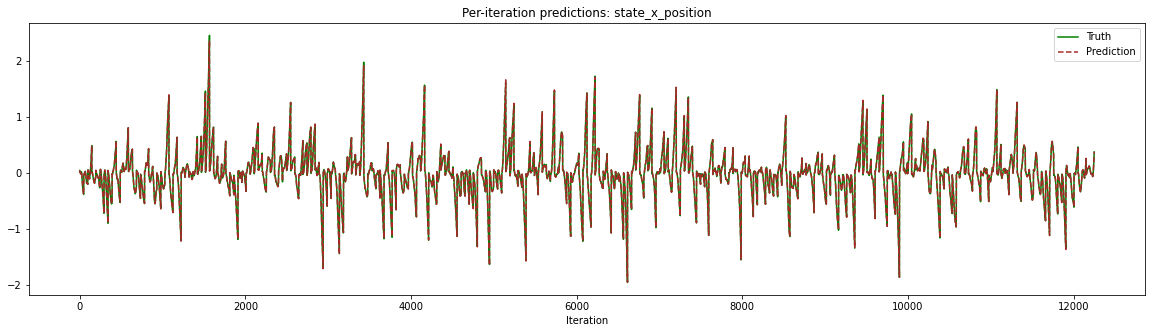

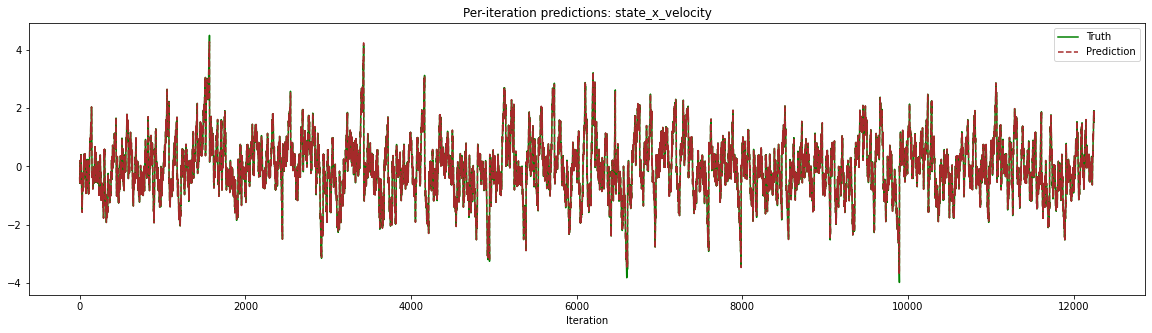

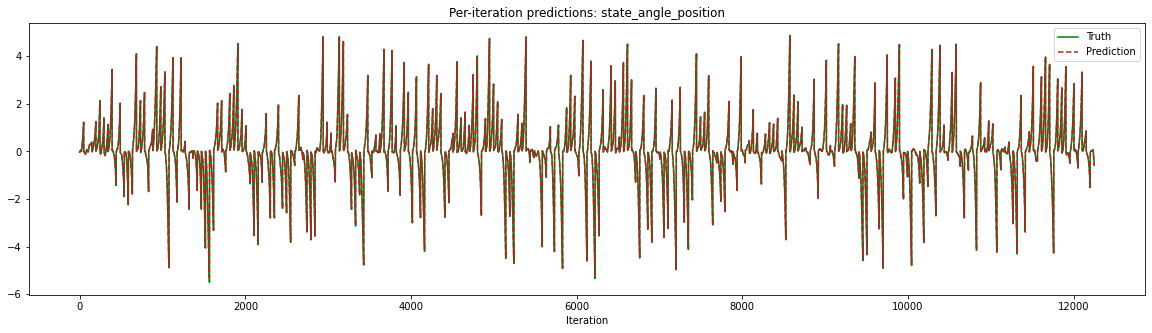

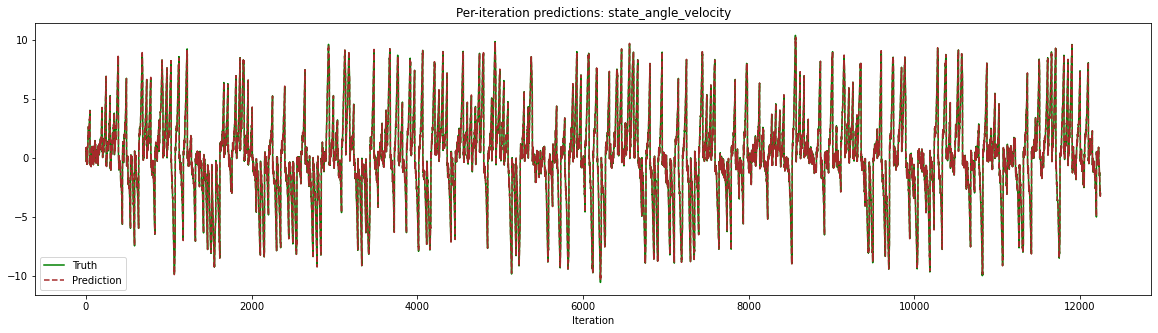

In [12]:
# Plot all prediction results
label_count = np.shape(y_preds)[1]
for i in range(label_count):
    fig = plt.figure(figsize=(20,5))
    plt.plot(y_test[:,i], "green")
    plt.plot(y_preds[:,i], "brown", linestyle='--')
    plt.title(f"Per-iteration predictions: {model.labels[i]}")
    plt.xlabel("Iteration")
    plt.legend(["Truth", "Prediction"])

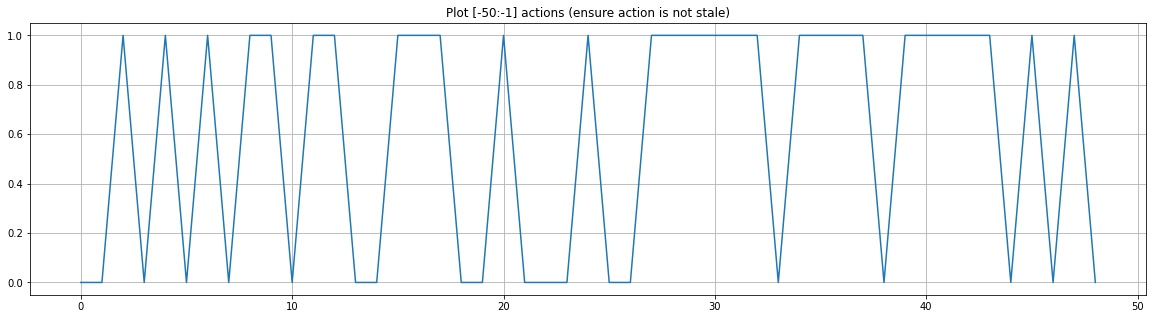

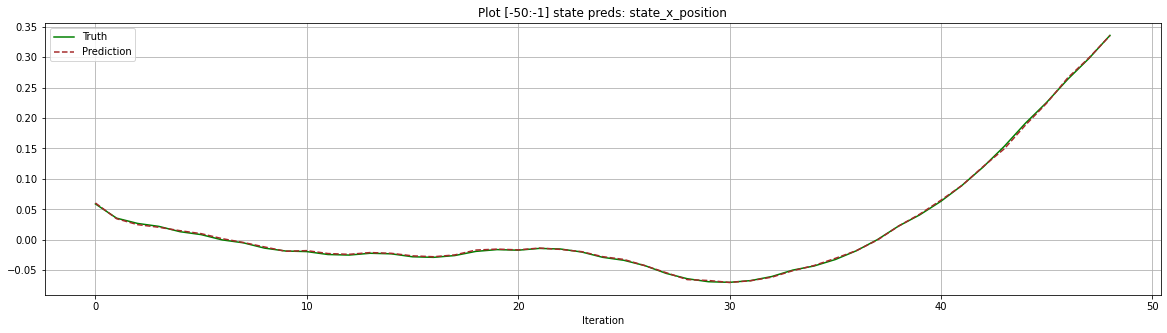

In [13]:
# Zoom in on a specific section
iteration_start = -50
iteration_stop = -1

# Define which input column is the action
action_col = cfg["simulator"]["actions"][0]

# Plot action changes -- zoomed in
fig = plt.figure(figsize=(20,5))
action_idx = model.features.index(action_col)
plt.title(f"Plot [{iteration_start}:{iteration_stop}] actions (ensure action is not stale)")
plt.plot(X_test[iteration_start:iteration_stop,action_idx])
plt.grid()
    
# Plot state (model output) changes -- zoomed in
fig = plt.figure(figsize=(20,5))
label_idx = 0
plt.title(f"Plot [{iteration_start}:{iteration_stop}] state preds: {model.labels[label_idx]}")
plt.plot(y_test[iteration_start:iteration_stop,label_idx], "green")
plt.plot(y_preds[iteration_start:iteration_stop,label_idx], "brown", linestyle='--')
plt.xlabel("Iteration")
plt.legend(["Truth", "Prediction"])
plt.grid()

### 4.2. Overall Prediction Score

In [14]:
# Select your scoring method: r2_score, root_mean_squared_error, or mean_squared_error
scoring_method = available_metrics["r2_score"]

In [15]:
# Evaluate the model using the test set
per_iteration_eval_table = model.evaluate(scoring_method, y_preds, y_test, marginal=True)

In [16]:
if (per_iteration_eval_table["score"] < 0.7).any():
    logger.warn("Per-iteration assessment R^2 is low. Please review your model.")

per_iteration_eval_table

,var,score
0,state_x_position,0.999923
1,state_x_velocity,0.999859
2,state_angle_position,0.999972
3,state_angle_velocity,0.999951


### 4.3. Sequential Predictions

In [17]:
# in order to run sequential predictions we need to segment
# the data by episodes so we can do multi-step predictions within each
# episode
X_test_grouped, y_test_grouped = model.get_test_set(grouped_per_episode=True)

In [18]:
# Feed the predicted output back into the input for full episodes.
preds_sequentially_grouped, labels_sequentially_grouped = model.predict_sequentially(X_test_grouped, y_test_grouped, return_flattened=False)

X (predict_sequentially) ---> (250, 49, 28)


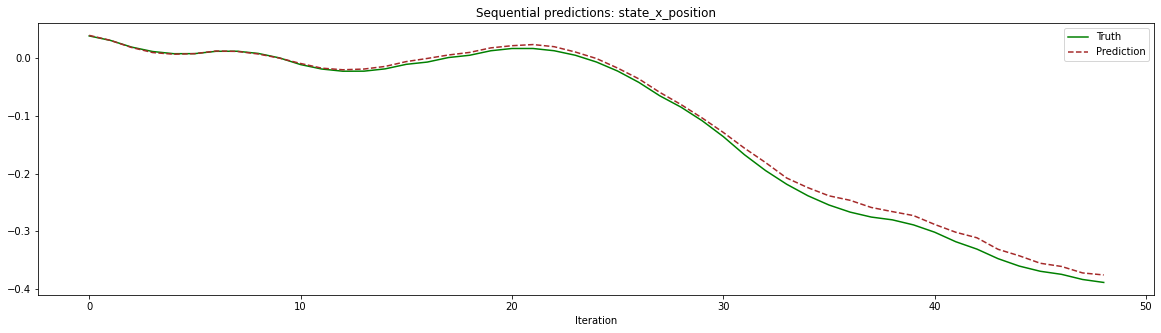

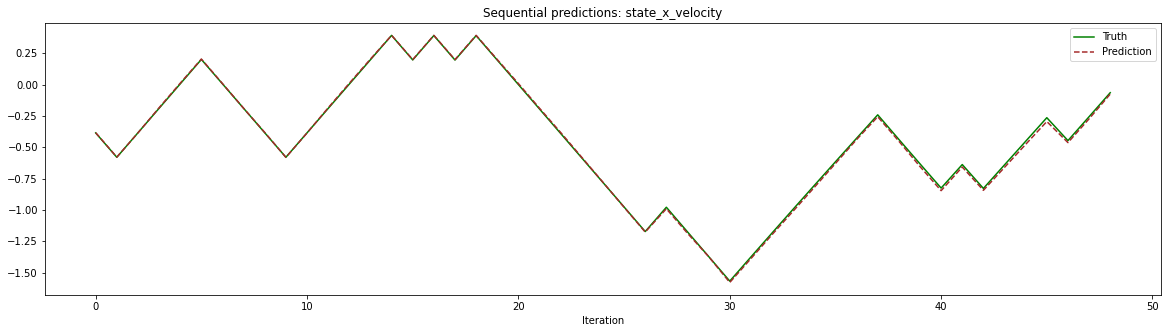

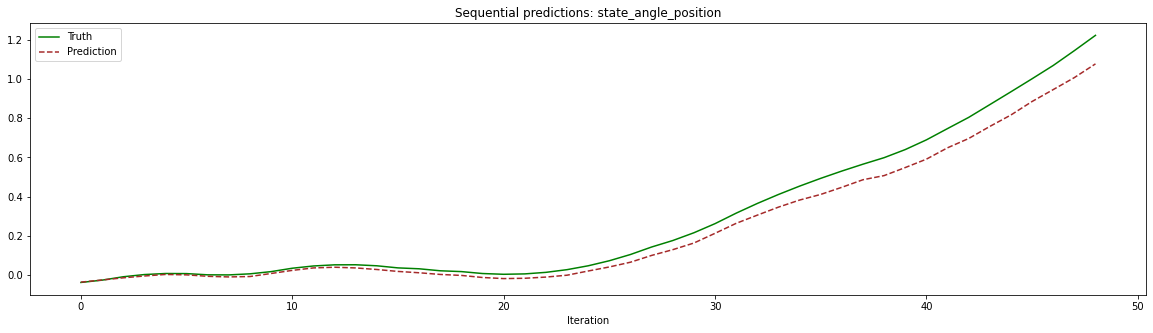

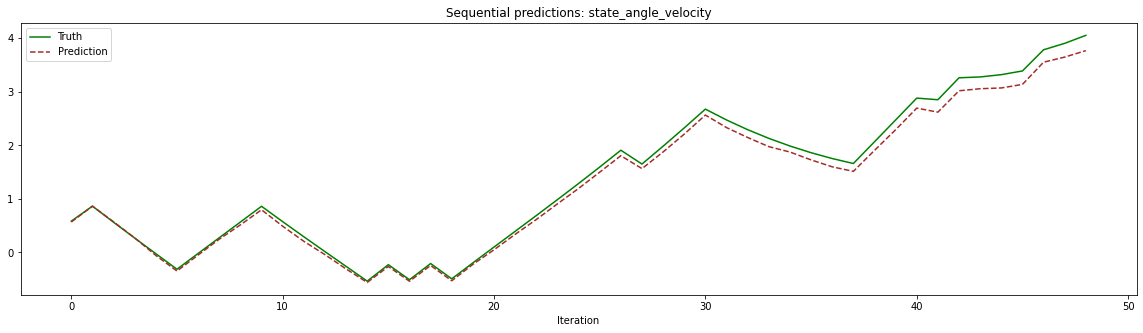

In [19]:
# Plot sequential predictions for first test episode. 
# Do you notice any error propagation (i.e., predictions deviate more from truth over time)?
label_count = np.shape(preds_sequentially_grouped[0])[1]
for i in range(label_count):
    fig = plt.figure(figsize=(20,5))
    plt.plot(y_test_grouped[0][:,i], "green")
    plt.plot(preds_sequentially_grouped[0][:,i], "brown", linestyle='--')
    plt.title(f"Sequential predictions: {model.labels[i]}")
    plt.xlabel("Iteration")
    plt.legend(["Truth", "Prediction"])

In [20]:
# Evaluate the model sequentially using the test set and output a scoring metric.
sequential_eval_table = model.evaluate(scoring_method, np.concatenate(preds_sequentially_grouped), np.concatenate(y_test_grouped), marginal=True)

In [21]:
if (sequential_eval_table["score"] < 0.7).any():
    logger.warn("Sequential assessment R^2 is low. Please review your model.")

sequential_eval_table

,var,score
0,state_x_position,0.997341
1,state_x_velocity,0.997835
2,state_angle_position,0.996386
3,state_angle_velocity,0.994748


## 5. Comparing Model Evaluations

If you want to compare various models, you can use the following section to save them in between runs.

1. Select appropriate "model_name" tag, and run this section
2. Change config through "config.yaml" (located at 'conf' folder)
3. Rerun from Model Build (Steps 1-4), until this section
4. Define a new value for "model_name" tag, and run this section again

In [22]:
# select model name, and feats to extract
model_name = "svr"

In [23]:
# per-iteration score
model_per_it_scores = copy.deepcopy(per_iteration_eval_table)

In [24]:
# initialize models dictionary if it doesn't exist already
if 'models_dict' not in locals():
    models_dict = dict()

In [25]:
# append tables to model using selected model name as key
models_dict[model_name] = (model_per_it_scores,)

In [26]:
# redefine column names if needed
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        for col_name in score_table.columns:
            if "score" in col_name and model_name not in col_name:
                score_table.rename(columns = {col_name:model_name+"_"+col_name}, inplace = True)

In [27]:
# concatenate across all models
all_scores = None
for model_name, score_tables in models_dict.items():
    for score_table in score_tables:
        if all_scores is None:
            all_scores = score_table
        else:
            all_scores = all_scores.merge(score_table,how='outer')

all_scores

,var,svr_score
0,state_x_position,0.999923
1,state_x_velocity,0.999859
2,state_angle_position,0.999972
3,state_angle_velocity,0.999951
